In [1]:
from google.colab import files
uploaded = files.upload()

Saving 3051crop_weight_200 (1).h5 to 3051crop_weight_200 (1).h5
Saving images.zip to images.zip
Saving source.zip to source.zip


In [2]:
!unzip images.zip

Archive:  images.zip
  inflating: images/imagesbaboon.bmp  
  inflating: images/imagesbaby_GT.bmp  
  inflating: images/imagesbird_GT.bmp  
  inflating: images/imagesmonarch.bmp  
  inflating: images/imageswoman_GT.bmp  


In [3]:
!unzip source.zip

Archive:  source.zip
  inflating: source/imagesbaboon.bmp  
  inflating: source/imagesbaby_GT.bmp  
  inflating: source/imagesbird_GT.bmp  
  inflating: source/imagesmonarch.bmp  
  inflating: source/imageswoman_GT.bmp  


In [4]:
import keras
import numpy
import matplotlib.pyplot as plt
import cv2
import skimage
from skimage.measure import compare_ssim as ssim
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D,Dense,MaxPooling2D
from keras.optimizers import Adam,SGD
import math
import os
%matplotlib inline

In [5]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))
    if(rmse!=0):
      return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores

In [6]:
def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height = h // factor
        new_width = w // factor
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)

In [8]:
prepare_images('source/', 2)

Saving imagesbaboon.bmp
Saving imageswoman_GT.bmp
Saving imagesmonarch.bmp
Saving imagesbird_GT.bmp
Saving imagesbaby_GT.bmp


In [9]:
for file in os.listdir('images/'):
    
    # open target and reference images
    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source/{}'.format(file))
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


imagesbaboon.bmp
PSNR: 35.42186468312118
MSE: 55.9777125
SSIM: 0.9600667435868956

imageswoman_GT.bmp
PSNR: 37.29942247275145
MSE: 36.32949561403509
SSIM: 0.9860663031091704

imagesmonarch.bmp
PSNR: 38.33790425195888
MSE: 28.60297393798828
SSIM: 0.9904142375037291

imagesbird_GT.bmp
PSNR: 39.59647324958838
MSE: 21.406925154320987
SSIM: 0.9885081585829526

imagesbaby_GT.bmp
PSNR: 42.50337137323986
MSE: 10.961360931396484
SSIM: 0.9885902627037796



In [10]:
# define the SRCNN model
def SRCNN():
    model = Sequential()
    model.add(Conv2D(filters=128,kernel_size=(9,9),kernel_initializer='glorot_uniform',activation='relu',
                     padding='valid',use_bias=True,input_shape=(None,None,1)))
    
    model.add(Conv2D(filters=64,kernel_size=(3,3),kernel_initializer='glorot_uniform',activation='relu',
                     padding='same',use_bias=True))
    
    model.add(Conv2D(filters=1,kernel_size=(5,5),kernel_initializer='glorot_uniform',activation='linear',
                     padding='valid',use_bias=True))
    adam = Adam(lr=0.0003)
    
    model.compile(optimizer=adam,loss='mean_squared_error',metrics=['mean_squared_error'])
    
    return model

In [11]:
srcnn = SRCNN()
srcnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 1)     1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


In [12]:
# define necessary image processing functions

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img

In [13]:
def predict(image_path):
    
    # load the srcnn model with weights
    srcnn = SRCNN()
    srcnn.load_weights('3051crop_weight_200 (1).h5')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize  
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Degraded Image: 
PSNR: 42.39065392498144
MSE: 11.24957778801322
SSIM: 0.9883646553873953

Reconstructed Image: 
PSNR: 45.10101781402432
MSE: 6.026981164092992
SSIM: 0.9915807815829996



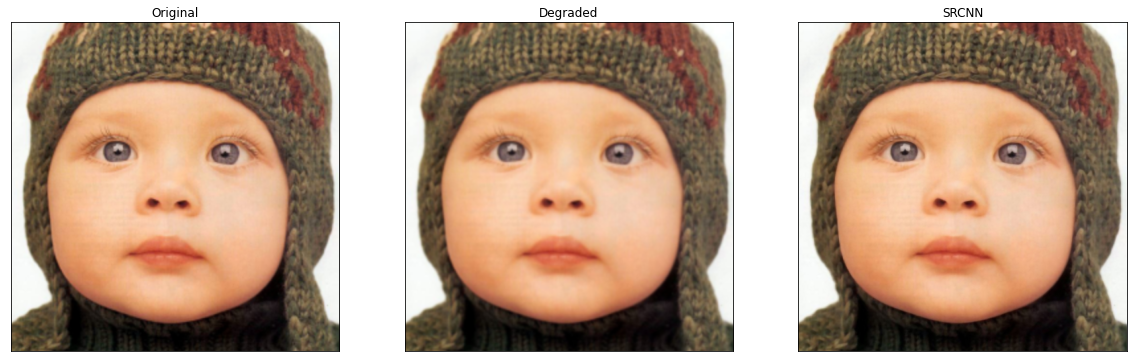

In [15]:
ref, degraded, output, scores = predict('images/imagesbaby_GT.bmp')
# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


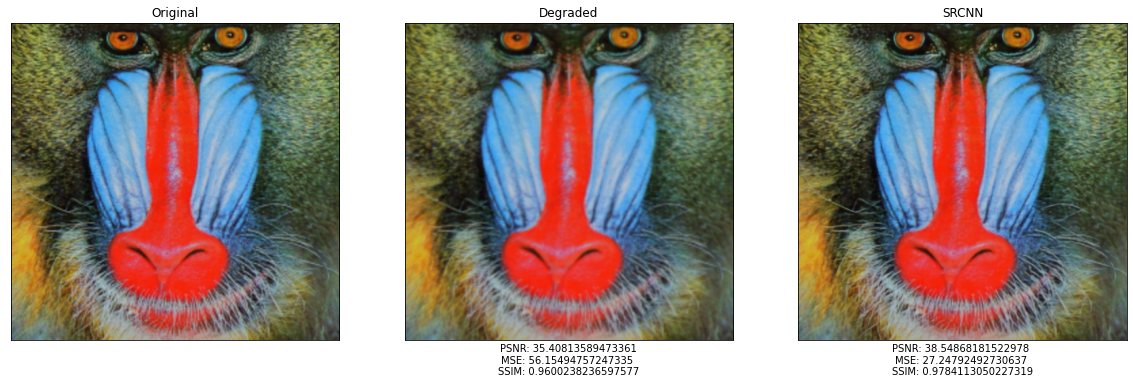

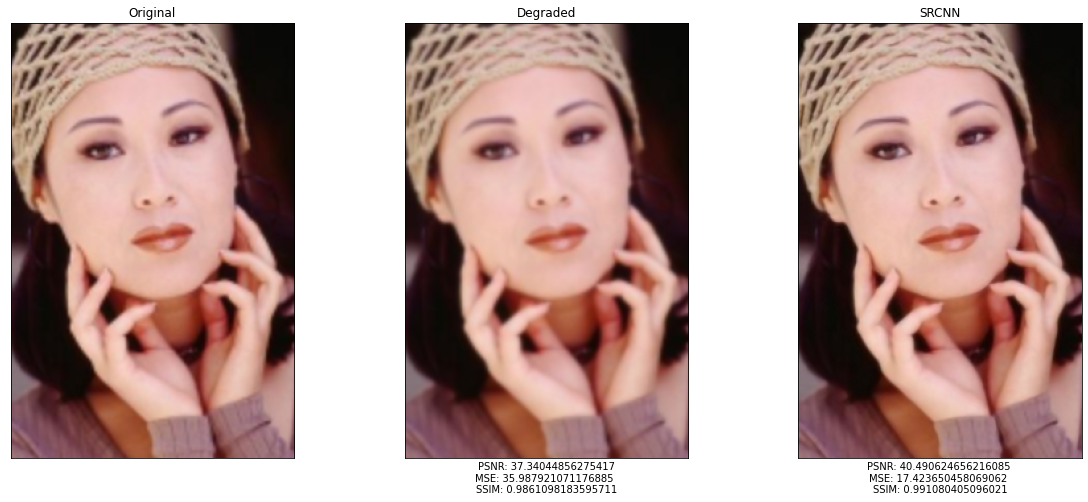

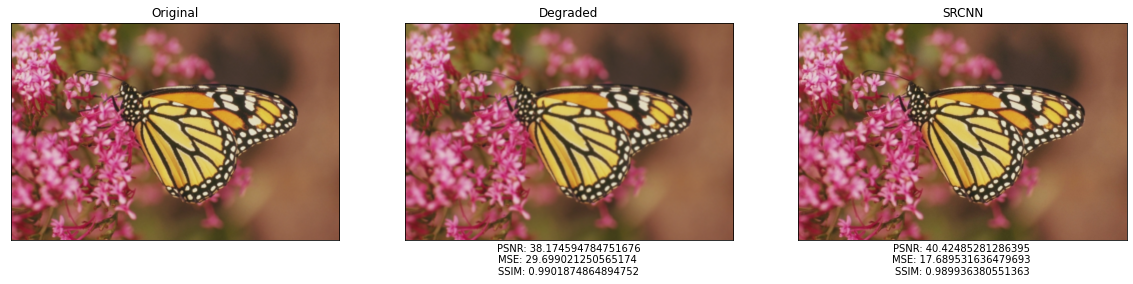

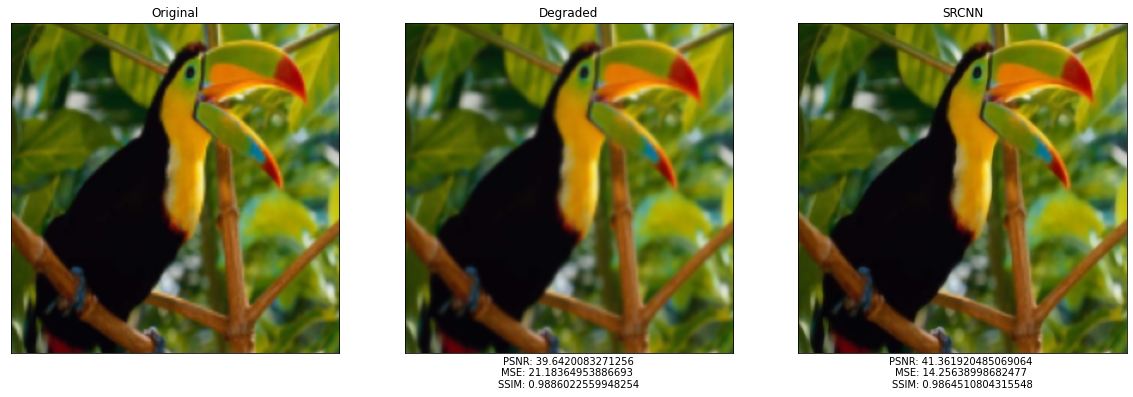

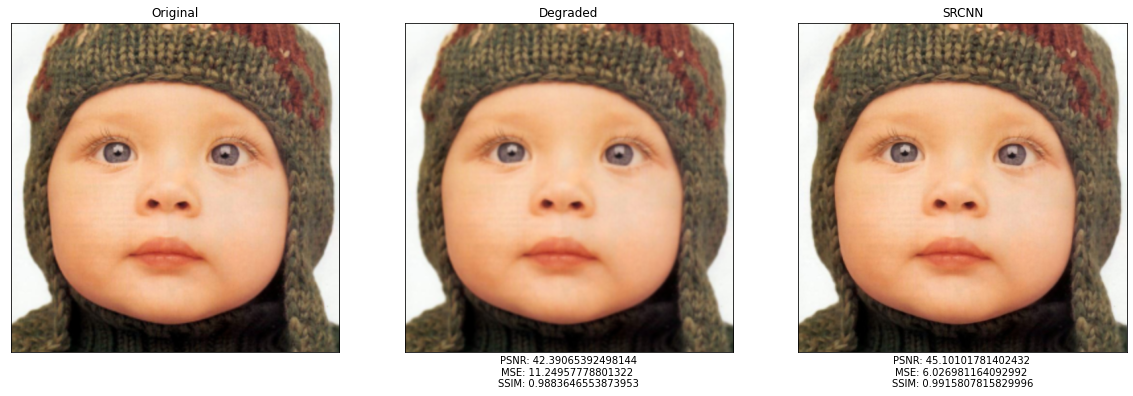

In [17]:
 for file in os.listdir('images'):   
    # perform super-resolution
    ref, degraded, output, scores = predict('images/{}'.format(file))
    
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
#     print('Saving {}'.format(file))
#     fig.savefig('output/{}.png'.format(os.path.splitext(file)[0])) 
#     plt.close()